# Water Pump Failure Analysis

## Goal
- Understand sensor behavior around failures
- Identify strongest predictors
- Build baseline classifiers for `machine_status`
## Approach
1. Load and sanity-check data
2. Clean missing values and define target
3. Explore time series + correlations
4. Train and compare models

In [ ]:
# Core numerics and data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Suppress noisy warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Consistent plot style
sns.set(style="whitegrid")

# Load Data & Initial Inspection

Sanity-check the dataset shape, schema, and class balance before cleaning.
This prevents modeling on corrupted or unexpectedly formatted data.

In [ ]:
# Load raw sensor data
df = pd.read_csv("sensor.csv")

# Quick shape check to confirm row/column count
print("Shape:", df.shape)

# Peek at the first rows to confirm column names and types
df.head()


Shape: (31817, 55)


,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [ ]:
# Schema, dtypes, and missingness overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31817 entries, 0 to 31816
Data columns (total 55 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      31817 non-null  int64  
 1   timestamp       31817 non-null  object 
 2   sensor_00       27798 non-null  float64
 3   sensor_01       31761 non-null  float64
 4   sensor_02       31815 non-null  float64
 5   sensor_03       31815 non-null  float64
 6   sensor_04       31815 non-null  float64
 7   sensor_05       31815 non-null  float64
 8   sensor_06       31578 non-null  float64
 9   sensor_07       31620 non-null  float64
 10  sensor_08       31114 non-null  float64
 11  sensor_09       31815 non-null  float64
 12  sensor_10       31815 non-null  float64
 13  sensor_11       31815 non-null  float64
 14  sensor_12       31815 non-null  float64
 15  sensor_13       31815 non-null  float64
 16  sensor_14       31816 non-null  float64
 17  sensor_15       0 non-null     

In [ ]:
# Class distribution to understand imbalance early
df['machine_status'].value_counts(normalize=True)

,proportion
machine_status,
NORMAL,0.872517
RECOVERING,0.127420
BROKEN,0.000063


# Data Cleaning & Preprocessing

Handle missing values, remove unusable sensors, and create a binary target for failure.
Because this is time-series-like data, forward/back fill is a pragmatic baseline.

In [ ]:
# Percent missing by column to spot problematic sensors
df.isna().mean().sort_values(ascending=False).head(10)

,0
sensor_15,1.000000
sensor_00,0.126316
sensor_08,0.022095
sensor_06,0.007512
sensor_07,0.006192
sensor_01,0.001760
sensor_02,0.000063
sensor_12,0.000063
sensor_13,0.000063
sensor_04,0.000063


In [ ]:
# Drop sensor_15 due to excessive missingness
df = df.drop(columns=['sensor_15'])

In [ ]:
# Time-order imputation: forward fill then backfill for leading gaps
df = df.fillna(method='ffill').fillna(method='bfill')

In [ ]:
# Confirm class counts after cleaning
df['machine_status'].value_counts()

,count
machine_status,
NORMAL,27761
RECOVERING,4054
BROKEN,2


In [ ]:
# Binary target: 1 = failure (BROKEN), 0 = normal/other
df['target'] = (df['machine_status'] == 'BROKEN').astype(int)

# Time Series Sanity Check

Plot `sensor_00` against failure points to visually inspect behavior around outages.
This helps validate whether failures appear as level shifts, spikes, or drifts.

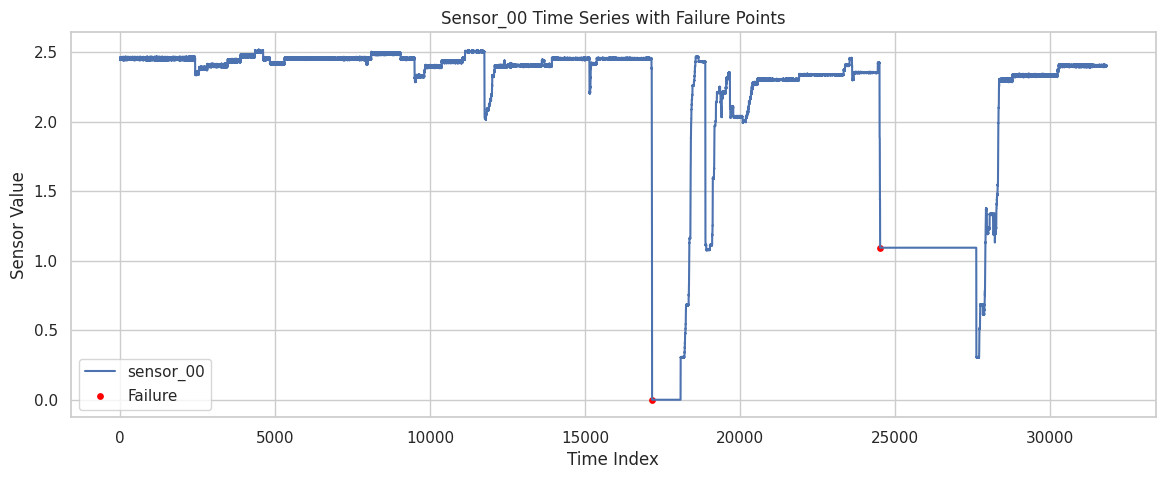

In [ ]:
# Visualize sensor_00 over time
plt.figure(figsize=(14,5))
plt.plot(df['sensor_00'], label='sensor_00')

# Overlay failure points for context
broken_idx = df[df['target'] == 1].index
plt.scatter(broken_idx, df.loc[broken_idx, 'sensor_00'],
            color='red', s=15, label='Failure')

plt.title("Sensor_00 Time Series with Failure Points")
plt.xlabel("Time Index")
plt.ylabel("Sensor Value")
plt.legend()
plt.show()

# Correlation Overview

Compute a sensor-level correlation matrix to identify redundant signals and
check which sensors move with the failure target.

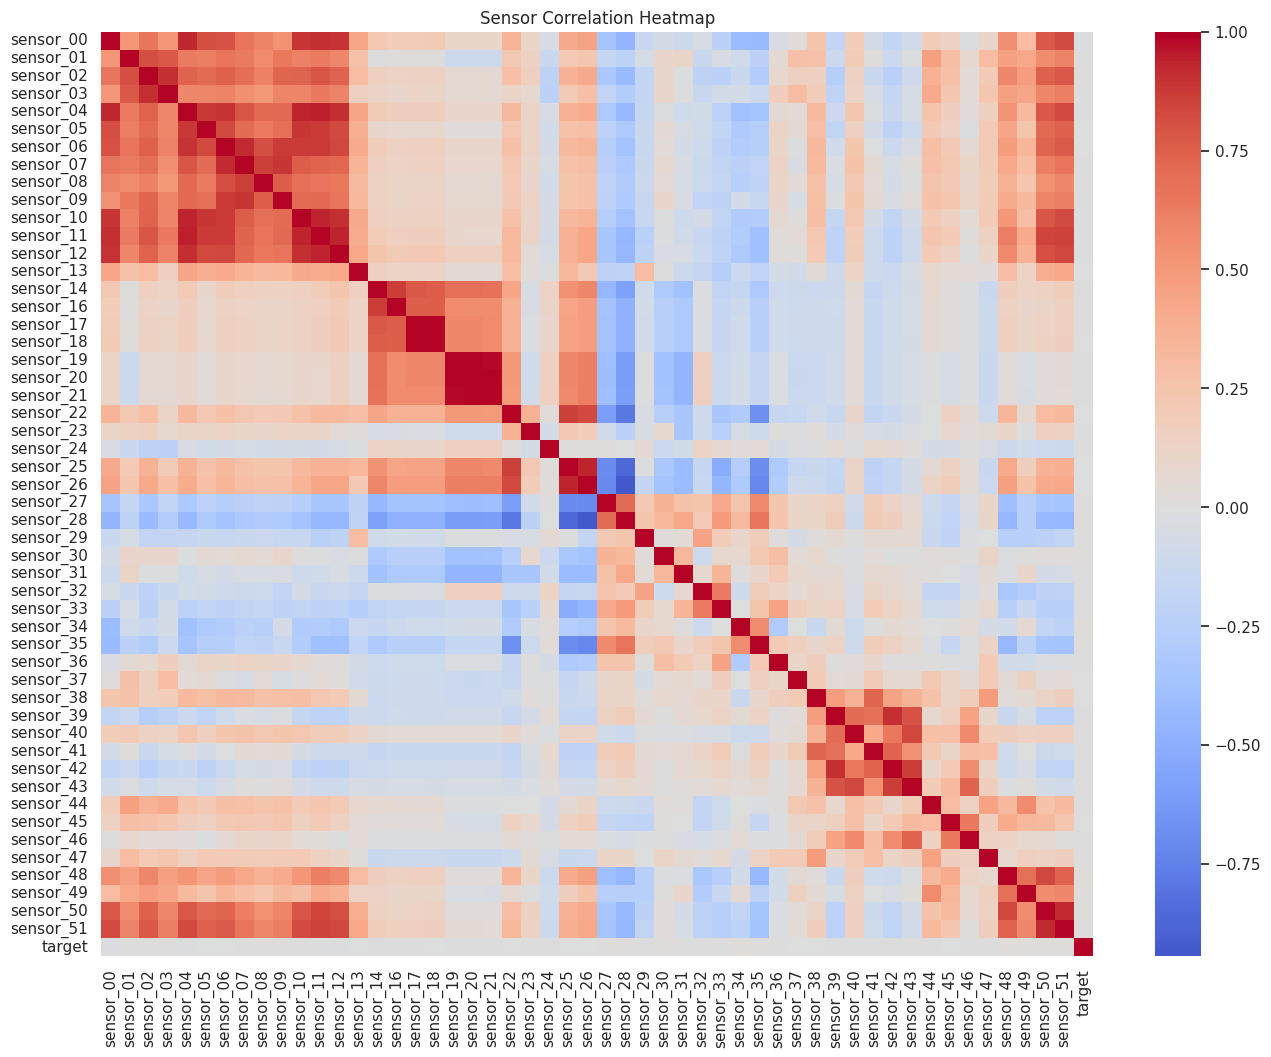

In [ ]:
# Identify sensor columns only
sensor_cols = [c for c in df.columns if c.startswith("sensor_")]

# Correlation across sensors plus target
corr = df[sensor_cols + ['target']].corr()

plt.figure(figsize=(16,12))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Sensor Correlation Heatmap")
plt.show()

# Strongest Predictors (Linear Association)

Use absolute correlation with the target as a quick, interpretable ranking.
This is not causality, but it guides feature focus.

In [ ]:
# Rank sensors by absolute correlation with target
target_corr = corr['target'].abs().sort_values(ascending=False)
target_corr.head(10)

,target
target,1.000000
sensor_00,0.020781
sensor_34,0.016882
sensor_04,0.014222
sensor_48,0.013125
sensor_35,0.012570
sensor_50,0.011592
sensor_11,0.010939
sensor_12,0.010250
sensor_49,0.009724


In [ ]:
# Select top 3 sensors (skip the target itself at index 0)
top_sensors = target_corr.index[1:4].tolist()
top_sensors

['sensor_00', 'sensor_34', 'sensor_04']

# Modeling Setup

Split data with stratification to preserve failure rate.
Use multiple baseline models to compare linear vs. non-linear behavior.

In [ ]:
# Features and label
X = df[sensor_cols]
y = df['target']

In [ ]:
# Stratified split to keep failure ratio consistent across train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [ ]:
# Scale features for Logistic Regression stability
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression baseline
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:,1]

print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7954
           1       0.00      0.00      0.00         1

    accuracy                           1.00      7955
   macro avg       0.50      0.50      0.50      7955
weighted avg       1.00      1.00      1.00      7955

ROC AUC: 0.9691978878551673


In [ ]:
# Random Forest captures non-linear interactions without scaling
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7954
           1       0.00      0.00      0.00         1

    accuracy                           1.00      7955
   macro avg       0.50      0.50      0.50      7955
weighted avg       1.00      1.00      1.00      7955

ROC AUC: 0.4973598189590143


In [ ]:
# XGBoost often performs well on tabular sensor data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_prob_xgb))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7954
           1       0.00      0.00      0.00         1

    accuracy                           1.00      7955
   macro avg       0.50      0.50      0.50      7955
weighted avg       1.00      1.00      1.00      7955

ROC AUC: 0.2880940407342218


# Feature Importance (Model-Based)

Use XGBoost importances to understand which sensors drive predictions.
This complements correlation-based ranking.

In [ ]:
# Extract and sort XGBoost feature importances
importance = pd.Series(
    xgb.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importance.head(10)


,0
sensor_47,0.303599
sensor_45,0.294124
sensor_35,0.180472
sensor_10,0.064366
sensor_37,0.055180
sensor_36,0.032385
sensor_50,0.021284
sensor_23,0.016979
sensor_27,0.014738
sensor_34,0.006054


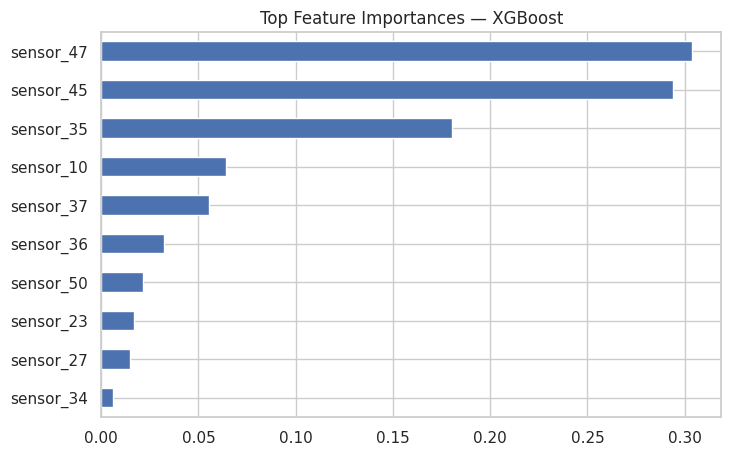

In [ ]:
# Plot top importances for quick comparison
importance.head(10).plot(kind="barh", figsize=(8,5))
plt.title("Top Feature Importances — XGBoost")
plt.gca().invert_yaxis()
plt.show()
